# Drought Prediction

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss

In [4]:
# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot

## Data Wrangling

#### Reading the input data

In [5]:
drought_df_train = pd.read_csv('data/train_timeseries.csv')
drought_df_test = pd.read_csv('data/test_timeseries.csv')
drought_df_test = pd.read_csv('data/validation_timeseries.csv')

drought_df = pd.concat([drought_df_train, drought_df_test, drought_df_test], axis=0)
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


#### Initial exploration 

In [6]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23838360 entries, 0 to 2268839
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.9+ GB


In [7]:
drought_df.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          20435100
dtype: int64

#### Removing missing values

In [8]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

#### Format Data

In [9]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [10]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month 
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int32
month            int32
day              int32
dtype: object

In [11]:
drought_df['fips'].nunique()

3108

In [12]:
drought_df['score'].round().value_counts()

score
0    2093262
1     579722
2     352327
3     221470
4     115419
5      41060
Name: count, dtype: int64

## EDA

In [13]:
drought_df.columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'year', 'month', 'day'],
      dtype='object')

#### Distribution of continuous variables

In [14]:
measures = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[measures]

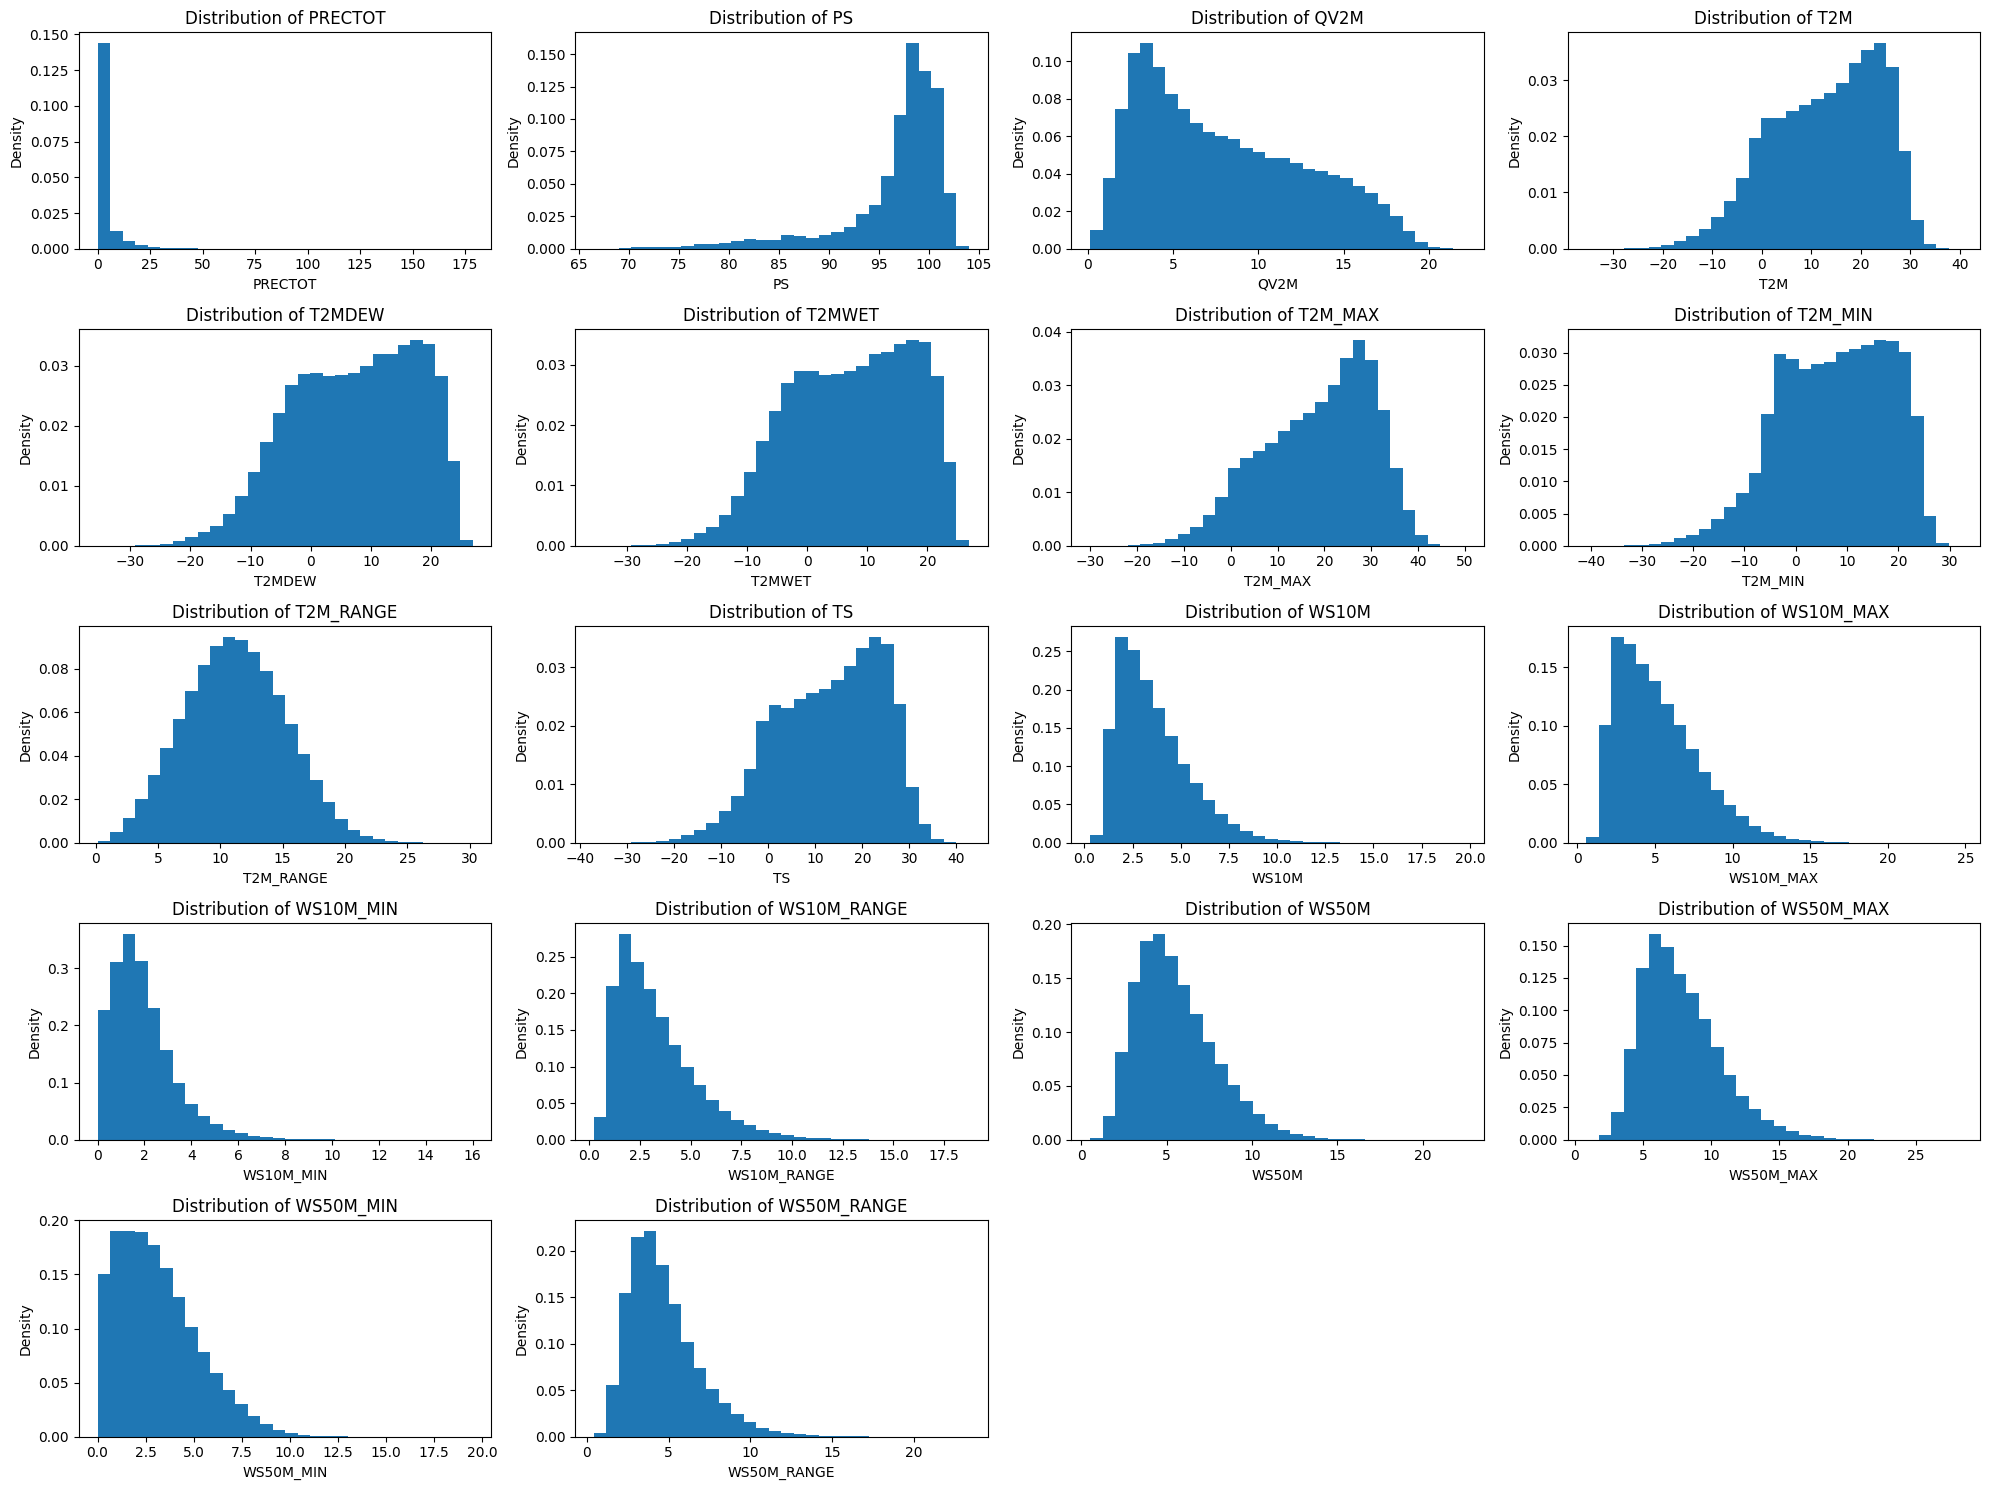

In [15]:
# Calculate number of rows and columns needed
n_measures = len(measures)
n_cols = 4  # Number of columns
n_rows = (n_measures + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot histograms 
for ax, col_name in zip(axes, measures):
    ax.hist(drought_df_measures[col_name], bins=30, density=True)  
    ax.set_xlabel(col_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {col_name}')

# Remove any empty subplots
for i in range(len(measures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Identifying outliers

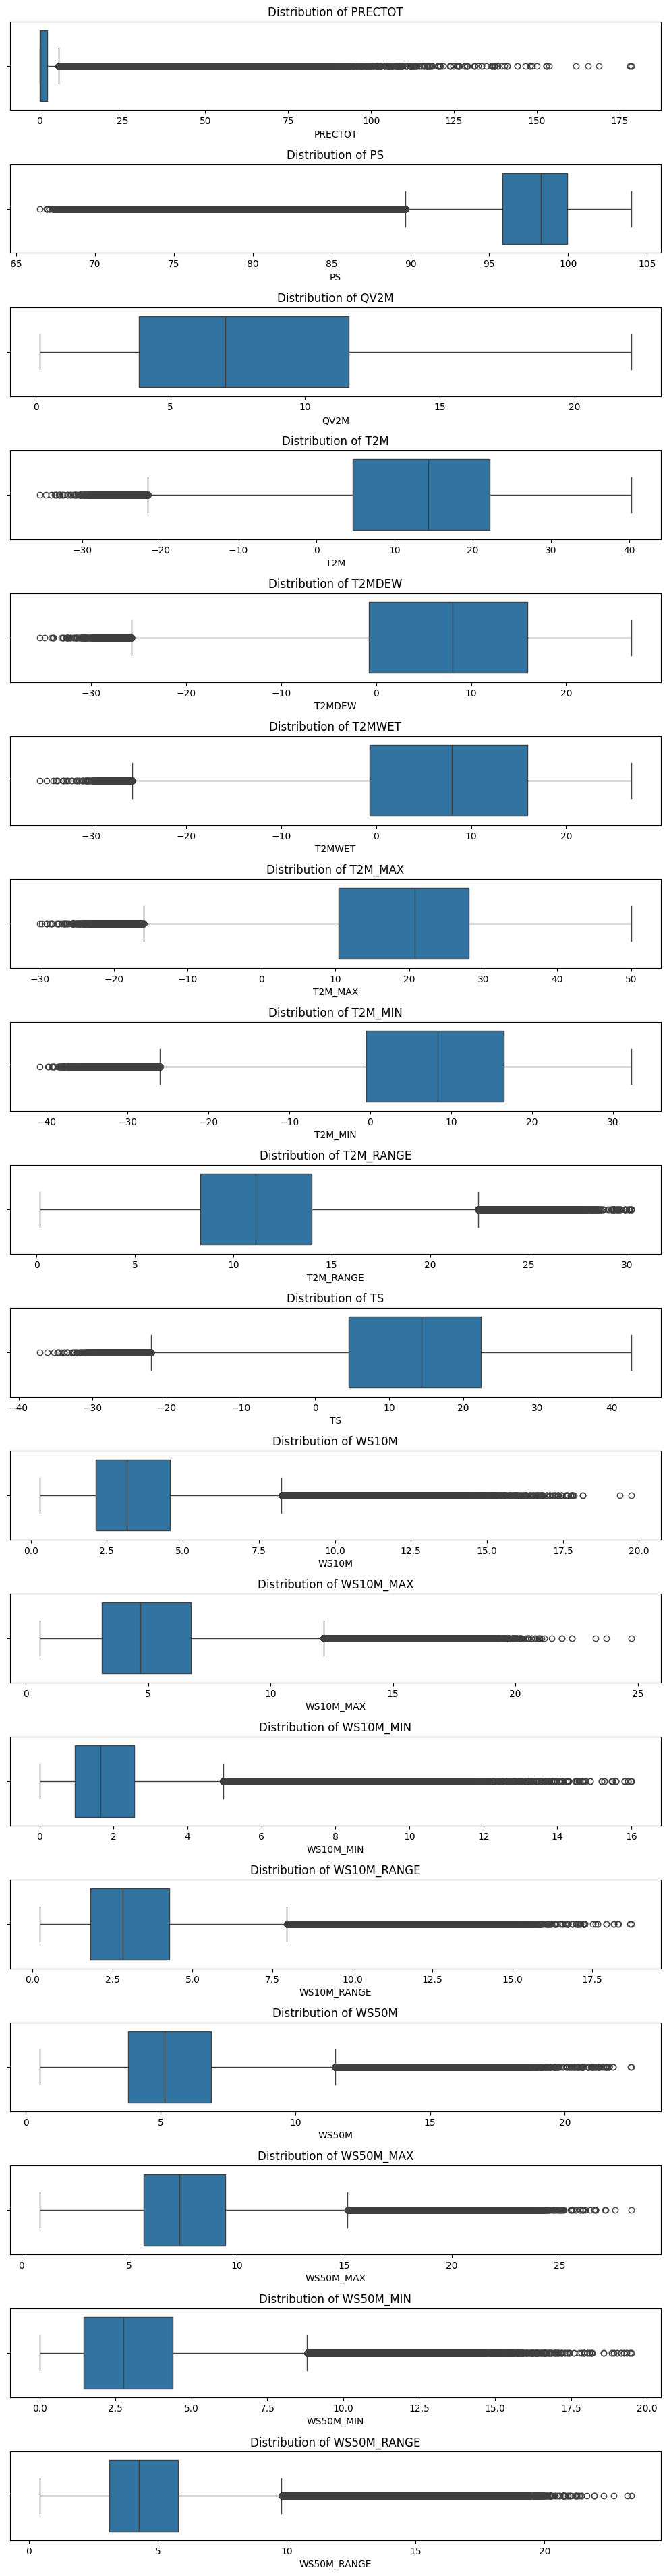

In [16]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

In [17]:
# Three Standard Deviations Rule (3-sigma Rule)
# Any data point greater than 𝜇+3𝜎 or less than μ−3σ is considered an outlier

print('Total rows = ', len(drought_df_measures.index))
print("{:<70} {:>10}".format('\nColumn Name', 'Outliers'))  # Print header

for i in drought_df_measures.select_dtypes(exclude=['object']).columns:
    num = len(drought_df_measures[
        (drought_df_measures[i] > drought_df_measures[i].mean() + 3 * drought_df_measures[i].std()) | 
        (drought_df_measures[i] < drought_df_measures[i].mean() - 3 * drought_df_measures[i].std())
    ])
    print("{:<70} {:>10}".format(f'Number of values beyond the standard outlier limit in {i} is:', num))


Total rows =  3403260

Column Name                                                             Outliers
Number of values beyond the standard outlier limit in PRECTOT is:           80854
Number of values beyond the standard outlier limit in PS is:                90414
Number of values beyond the standard outlier limit in QV2M is:                  0
Number of values beyond the standard outlier limit in T2M is:                5649
Number of values beyond the standard outlier limit in T2MDEW is:             2589
Number of values beyond the standard outlier limit in T2MWET is:             2164
Number of values beyond the standard outlier limit in T2M_MAX is:            4381
Number of values beyond the standard outlier limit in T2M_MIN is:            8148
Number of values beyond the standard outlier limit in T2M_RANGE is:          4496
Number of values beyond the standard outlier limit in TS is:                 5921
Number of values beyond the standard outlier limit in WS10M is:             

In [18]:
# Function to filter outliers based on the 3-sigma rule
def remove_outliers(df, columns):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        upper_limit = mean + 3 * std
        lower_limit = mean - 3 * std
        df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]
    return df

# Remove outliers
cleaned_drought_df_measures = remove_outliers(drought_df_measures, measures)

# Print the number of rows before and after removing outliers
print(f'Total rows before removing outliers: {len(drought_df_measures)}')
print(f'Total rows after removing outliers: {len(cleaned_drought_df_measures)}')
print(f'Number of outliers: {len(drought_df_measures)-len(cleaned_drought_df_measures)}')


Total rows before removing outliers: 3403260
Total rows after removing outliers: 3054658
Number of outliers: 348602


#### Distribution of categorical variables

In [19]:
categorical = ['score','year','month','day']
drought_categorical = drought_df[categorical]

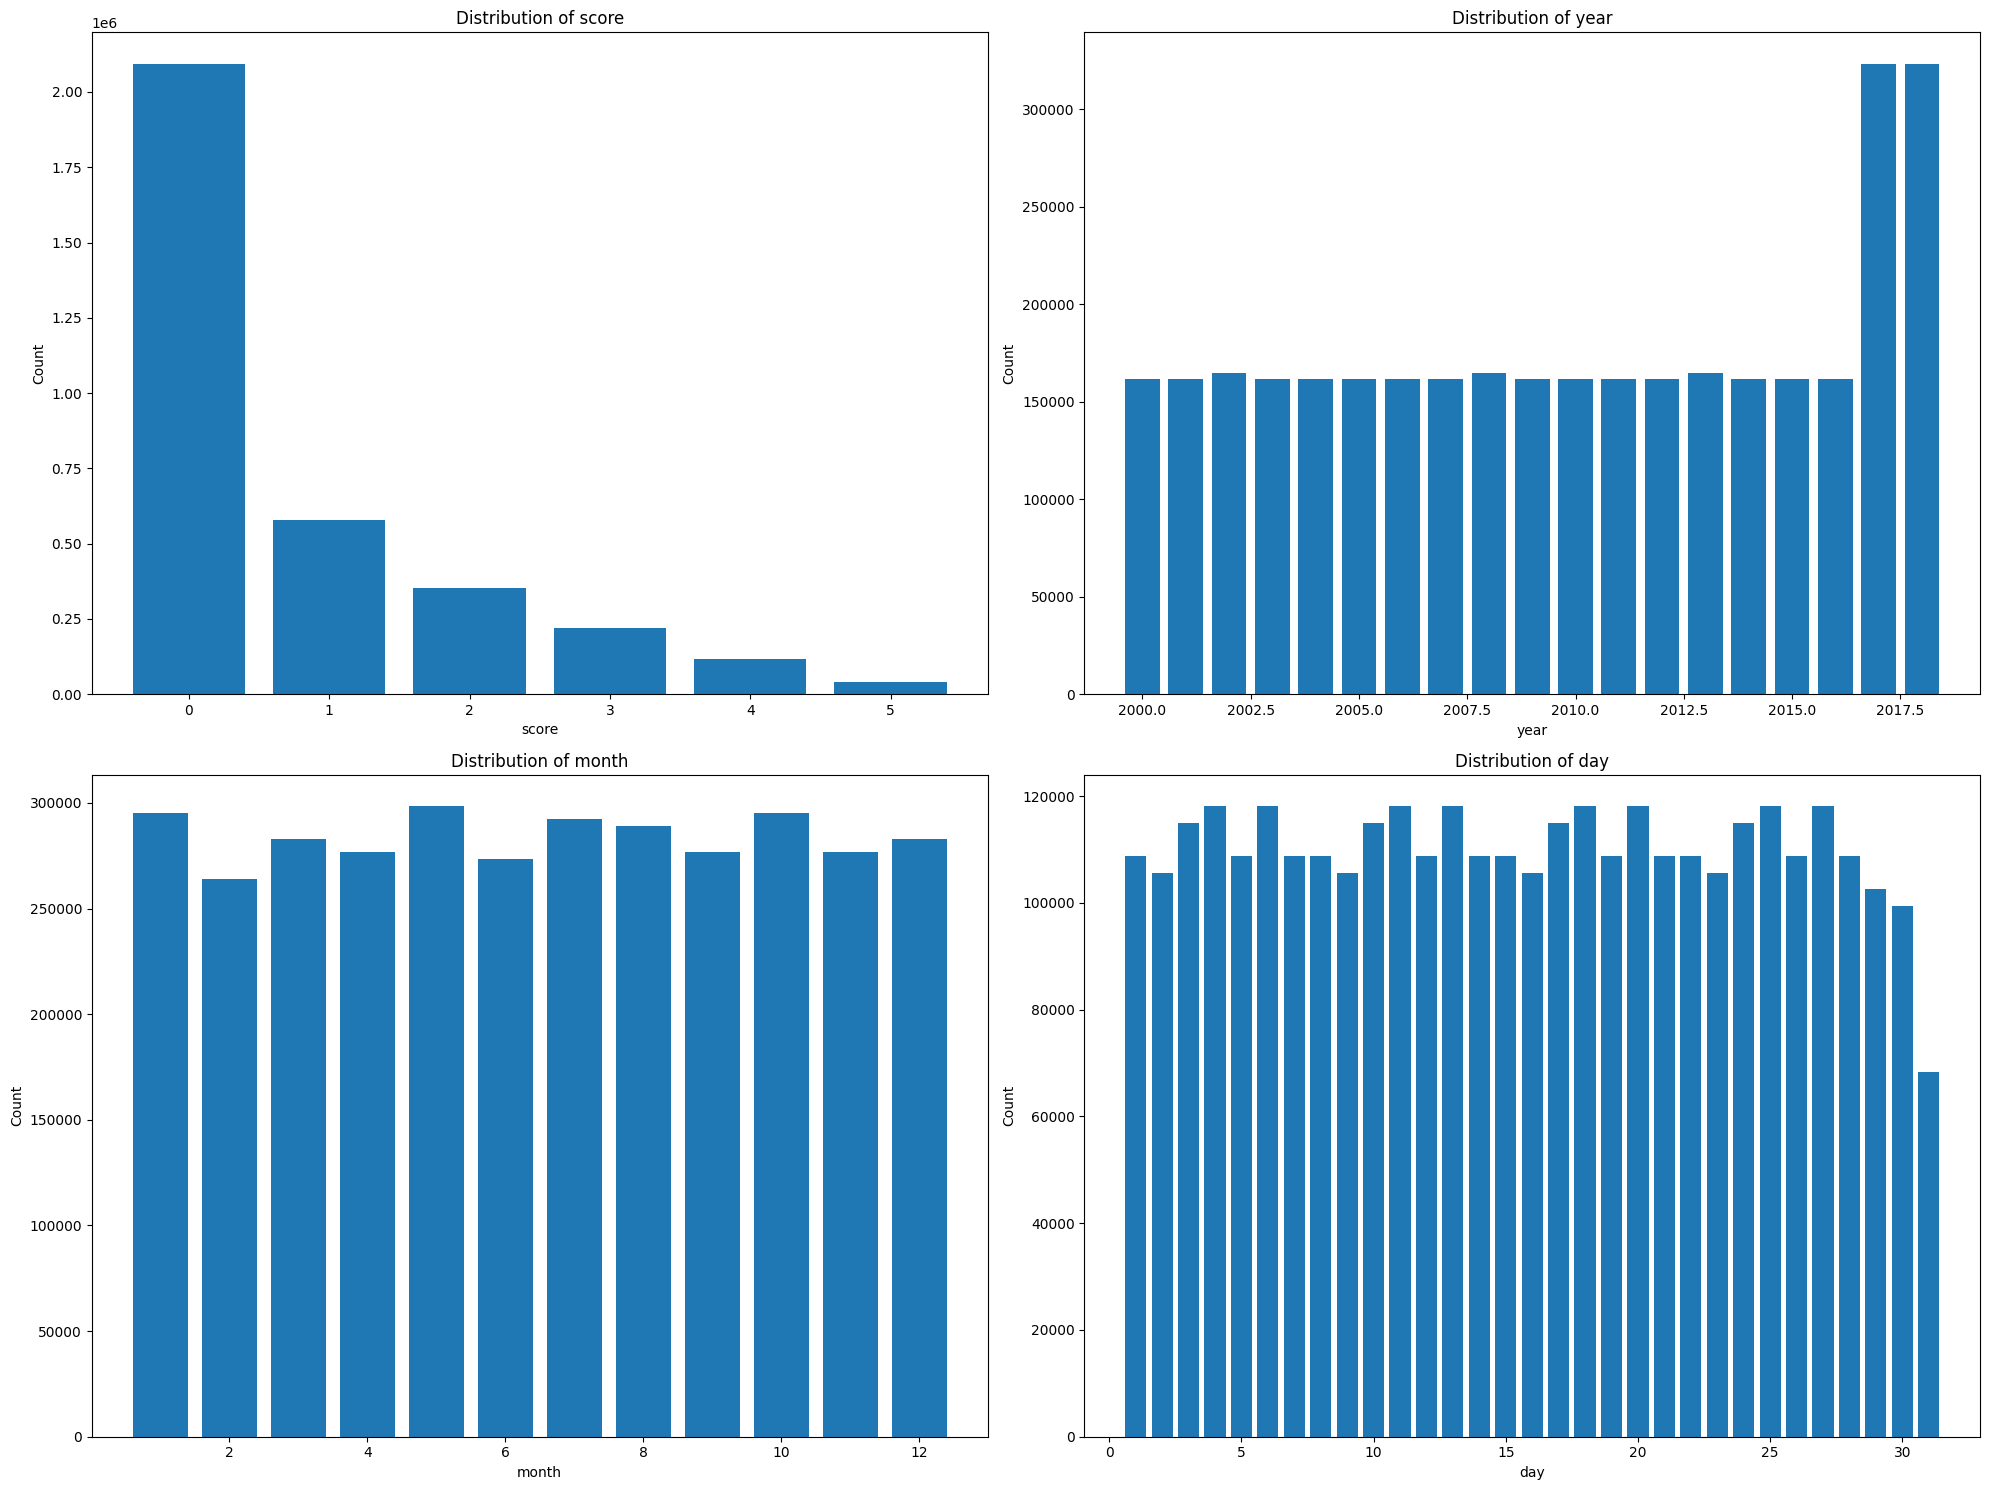

In [20]:
# Calculate number of rows and columns needed
n_measures = len(categorical)
n_cols = 2  # Number of columns
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot bar charts
for ax, col_name in zip(axes, categorical):
    ax.bar(drought_categorical[col_name].value_counts().index, drought_categorical[col_name].value_counts().values)  
    ax.set_xlabel(col_name)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {col_name}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


#### Correlation

In [21]:
correlati_plot = drought_df_measures.corr()
correlati_plot.style.background_gradient(cmap='coolwarm')


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.070030,0.246913,0.098108,0.233058,0.232971,0.031924,0.148720,-0.301812,0.094613,0.050756,0.061878,0.023471,0.067020,0.068471,0.078519,0.056302,0.048127
PS,0.070030,1.000000,0.284979,0.166492,0.342553,0.342854,0.114063,0.210599,-0.228937,0.166094,-0.076533,-0.131189,0.025855,-0.194386,-0.038578,-0.087301,0.039750,-0.152658
QV2M,0.246913,0.284979,1.000000,0.873016,0.959256,0.960861,0.807776,0.908187,-0.076827,0.865432,-0.234358,-0.263592,-0.118249,-0.272872,-0.215658,-0.258928,-0.089876,-0.251497
T2M,0.098108,0.166492,0.873016,1.000000,0.915222,0.915924,0.983423,0.981708,0.234725,0.997510,-0.216632,-0.226795,-0.134891,-0.211852,-0.202700,-0.215222,-0.120265,-0.164908
T2MDEW,0.233058,0.342553,0.959256,0.915222,1.000000,0.999897,0.857273,0.940396,-0.019460,0.906958,-0.245806,-0.273921,-0.124984,-0.282110,-0.211792,-0.251809,-0.089908,-0.242158
T2MWET,0.232971,0.342854,0.960861,0.915924,0.999897,1.000000,0.857841,0.941310,-0.020243,0.907707,-0.245848,-0.273951,-0.125142,-0.282041,-0.212211,-0.252215,-0.090227,-0.242379
T2M_MAX,0.031924,0.114063,0.807776,0.983423,0.857273,0.857841,1.000000,0.938077,0.398040,0.980195,-0.224932,-0.227758,-0.150656,-0.202246,-0.204664,-0.204505,-0.140219,-0.131566
T2M_MIN,0.148720,0.210599,0.908187,0.981708,0.940396,0.941310,0.938077,1.000000,0.055591,0.979203,-0.215945,-0.233246,-0.122900,-0.228826,-0.208277,-0.235373,-0.104761,-0.206277
T2M_RANGE,-0.301812,-0.228937,-0.076827,0.234725,-0.019460,-0.020243,0.398040,0.055591,1.000000,0.232055,-0.076446,-0.038776,-0.108763,0.023048,-0.038337,0.033873,-0.126714,0.167047
TS,0.094613,0.166094,0.865432,0.997510,0.906958,0.907707,0.980195,0.979203,0.232055,1.000000,-0.198834,-0.209553,-0.119974,-0.198971,-0.190531,-0.202416,-0.110346,-0.157773


Attributes QV2M, T2M, T2MDEW, T2MWET, T2M_MAX, T2M_MIN and TS have shown strong positive correlation  
Similary WS10M, WS10M_MAX and WS10M_MIN have shown a strong positve correlation  
Likewise, WS50M, WS50M_MAX and WS50M_MIN show strong positive correlation  
However, from the scatter plots above, we see significant variance between the data points, despite the strong positive correlation. Hence we'll retain all these variables, and try other feature selection methods.

In [24]:
drought_df.to_csv('data/all_timeseries.csv', encoding='utf-8', index=False)